In [1]:
%cd supervised
%load_ext autoreload
%autoreload 2

import data
import train
import evaluate
import models
import torch

/home/maarten/Documents/masterthesis/supervised


# Dataset analysis

In [ ]:
import glob
from lxml import etree

positives = []
negatives = []
for path in glob.glob('../training_data/*.xml'):
    with open(path, 'r') as f:
        xml = etree.fromstring(f.read().encode('utf-8'))
    pos = len(xml.xpath('/pdf2xml/page/text[@is-speech="true"]'))
    neg = len(xml.xpath('/pdf2xml/page/text[@is-speech="false"]'))
    positives.append(pos)
    negatives.append(neg)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

sns.distplot(positives, axlabel='positive samples per file')
fig = plt.gcf()
plt.show()
fig.savefig('distribution.pdf')

print(tabulate([['Positives samples', sum(positives)],
                ['Negative samples', sum(negatives)]]))

# Training and evaluation

In [2]:
num_clusters = 5
window_size = 11
window_label = 6

files = [f'../clusterlabeled-fixed-{num_clusters}/18{i:03d}.xml' for i in [1, 2, 3]]
test_files = [f'../clusterlabeled-fixed-{num_clusters}/18{i:03d}.xml' for i in [1]]

full_window_dataset = data.GermanDataset(files, num_clusters, 584, 584, window_size, window_label,
                                        cluster_fmt=data.ClusterFmt.FULL_WINDOW)
only_center_dataset = data.GermanDataset(files, num_clusters, 584, 584, window_size, window_label,
                                        cluster_fmt=data.ClusterFmt.ONLY_CENTRAL)
only_idx_dataset = data.GermanDataset(files, num_clusters, 584, 584, window_size, window_label,
                                        cluster_fmt=data.ClusterFmt.FULL_WINDOW_ONLY_IDX)

Creating dictionary:  67%|██████▋   | 2/3 [00:00<00:00, 18.31it/s]

Retrieved 584 positive samples, 28169 negative samples.


Creating dictionary:  67%|██████▋   | 2/3 [00:00<00:00, 17.40it/s]

Retrieved 584 positive samples, 28169 negative samples.


100%|██████████| 584/584 [00:11<00:00, 49.47it/s]


Retrieved 584 positive samples, 28169 negative samples.


# Test the different kinds of cluster handling
# 1000 samples

In [31]:
params = train.CNNParams(
    embed_size=300,
    dropout=0.0,
    epochs=100,
    filters=[(33, 3), (34, 5), (33, 7)],
    num_layers=1
)

optim_fn = lambda p: torch.optim.Adadelta(p, weight_decay=0.01)

no_labels = evaluate.cross_val(10, 400, lambda r: models.NoClusterLabels(r, params.dropout),
                               optim_fn, only_idx_dataset, params, 10)
only_center = evaluate.cross_val(10, 400, lambda r: models.CategoricalClusterLabelsOnlyCenter(r, num_clusters, params.dropout),
                                 optim_fn, only_center_dataset, params, 10)
full_window = evaluate.cross_val(10, 400, lambda r: models.CategoricalClusterLabels(r, num_clusters, window_size, params.dropout),
                                 optim_fn, full_window_dataset, params, 10)
with_cnn = evaluate.cross_val(10, 400, lambda r: models.ClusterLabelsCNN(r, num_clusters, params.dropout),
                              optim_fn, only_idx_dataset, params, 10)

100%|██████████| 10/10 [00:50<00:00,  5.10s/it]


Average convergence speed


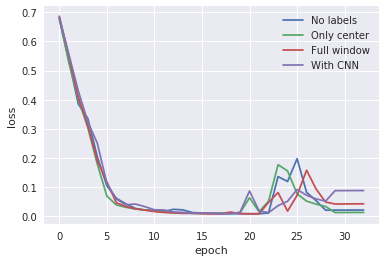


Average P/R curve


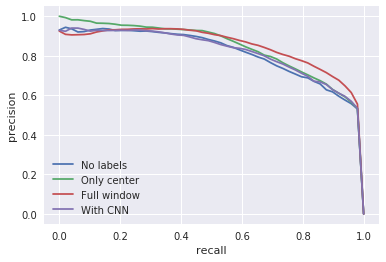


Score table:
model          F1 mean    F1 stddev    AoC mean     AoC std    Area under averaged curve
-----------  ---------  -----------  ----------  ----------  ---------------------------
No labels     0.754607   0.0199201     0.751184  0.0100659                      0.815362
Only center   0.768083   0.0127722     0.767141  0.00939043                     0.843355
Full window   0.80303    0.00715122    0.774677  0.0118079                      0.848645
With CNN      0.765468   0.0177077     0.751954  0.00846181                     0.820079

AP plots:


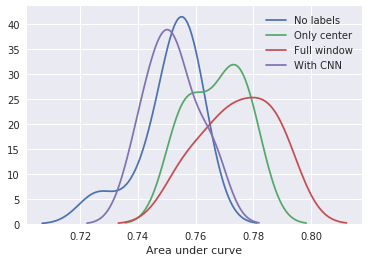

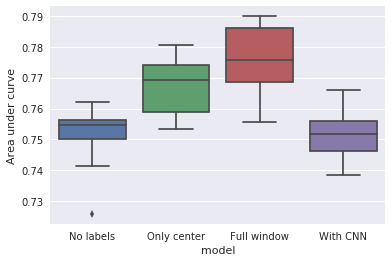

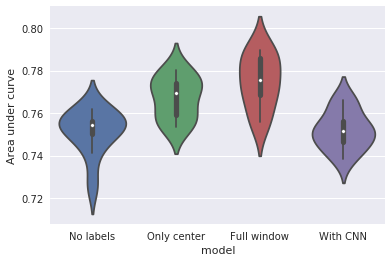


F1 plots:


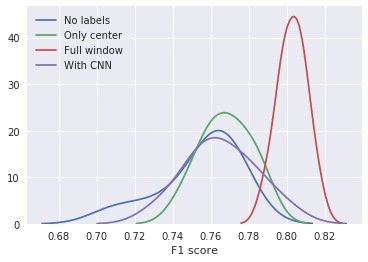

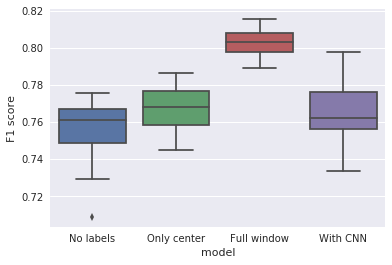

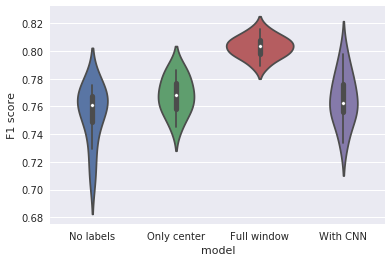


Statistical significance (dependent T-test):
F1 score
                 No labels    Only center    Full window       With CNN
-----------  -------------  -------------  -------------  -------------
No labels    nan              0.196999       8.49491e-05    0.16775
Only center    0.196999     nan              8.35092e-05    0.681121
Full window    8.49491e-05    8.35092e-05  nan              8.56394e-05
With CNN       0.16775        0.681121       8.56394e-05  nan

Area under curve
                 No labels    Only center    Full window      With CNN
-----------  -------------  -------------  -------------  ------------
No labels    nan               0.00781195    0.000404543    0.808556
Only center    0.00781195    nan             0.186269       0.00513455
Full window    0.000404543     0.186269    nan              0.0017789
With CNN       0.808556        0.00513455    0.0017789    nan


In [38]:
evaluate.analyze({'No labels': no_labels,
                  'Only center': only_center,
                  'Full window': full_window,
                  'With CNN': with_cnn},
                 'model', '../report/figures/results/models')

# Test regularization methods

In [15]:
params = train.CNNParams(
    embed_size=300,
    dropout=0.0,
    epochs=100,
    filters=[(33, 3), (34, 5), (33, 7)],
    num_layers=1
)

optim_no_decay = lambda p: torch.optim.Adadelta(p)

dropout_tests = []
dropout_values = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
for value in dropout_values:
    params.dropout = value
    dropout_tests.append(evaluate.cross_val(10, 400,
                                            lambda r: models.CategoricalClusterLabels(r, num_clusters, window_size, params.dropout),
                                            optim_no_decay, full_window_dataset, params))
    
decay_tests = []
decay_values = [0, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
for value in decay_values:
    params.dropout = 0.0
    optim_decay = lambda p: torch.optim.Adadelta(p, weight_decay=value)
    decay_tests.append(evaluate.cross_val(10, 400,
                                          lambda r: models.CategoricalClusterLabels(r, num_clusters, window_size, params.dropout),
                                          optim_decay, full_window_dataset, params))

100%|██████████| 10/10 [02:21<00:00, 14.16s/it]


Average convergence speed


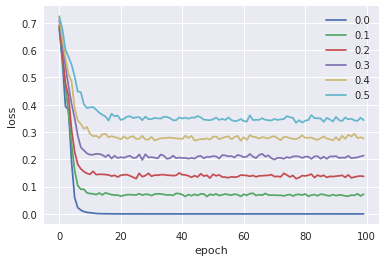


Average P/R curve


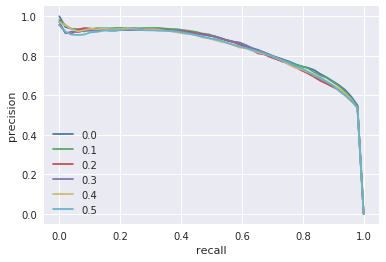


Score table:
  dropout rate    F1 mean    F1 stddev    AoC mean     AoC std    Area under averaged curve
--------------  ---------  -----------  ----------  ----------  ---------------------------
           0     0.790996   0.00886299    0.753884  0.00944525                     0.839916
           0.1   0.784048   0.0134678     0.759779  0.0124664                      0.841375
           0.2   0.772331   0.00894773    0.755667  0.0141013                      0.831937
           0.3   0.775298   0.0105432     0.758314  0.0111145                      0.83396
           0.4   0.775281   0.0137571     0.758894  0.00943794                     0.83162
           0.5   0.7762     0.00954646    0.75585   0.0111458                      0.828541

AP plots:


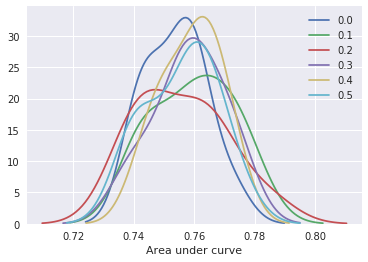

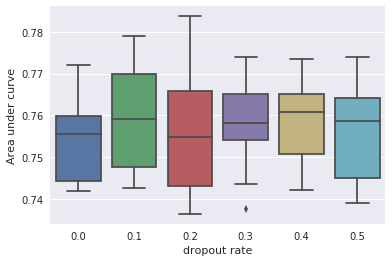

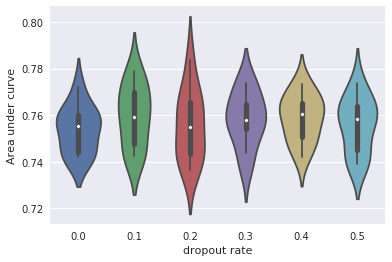


F1 plots:


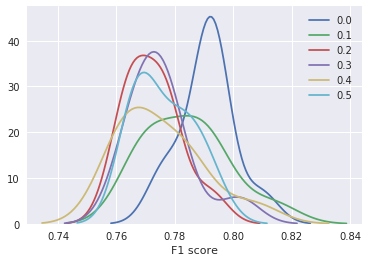

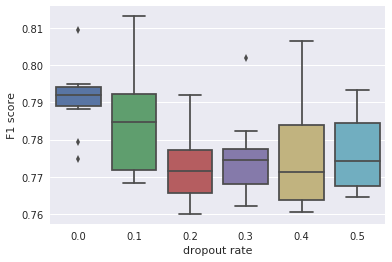

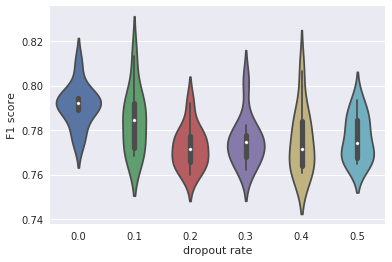


Statistical significance (dependent T-test):
F1 score
              0.0           0.1           0.2           0.3           0.4         0.5
---  ------------  ------------  ------------  ------------  ------------  ----------
0    nan             0.249995      0.00163708    0.00389175    0.0299133     0.003019
0.1    0.249995    nan             0.0320159     0.229953      0.00269808    0.117434
0.2    0.00163708    0.0320159   nan             0.461365      0.590095      0.427847
0.3    0.00389175    0.229953      0.461365    nan             0.998153      0.858281
0.4    0.0299133     0.00269808    0.590095      0.998153    nan             0.842342
0.5    0.003019      0.117434      0.427847      0.858281      0.842342    nan

Area under curve
            0.0         0.1         0.2         0.3         0.4         0.5
---  ----------  ----------  ----------  ----------  ----------  ----------
0    nan           0.405092    0.74764     0.397779    0.39864     0.600897
0.1    0.405092  n

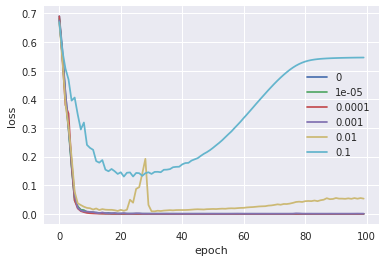


Average P/R curve


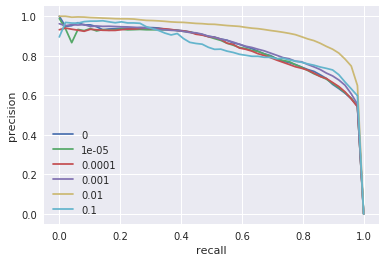


Score table:
  decay value    F1 mean    F1 stddev    AoC mean    AoC std    Area under averaged curve
-------------  ---------  -----------  ----------  ---------  ---------------------------
       0        0.78318    0.0108918     0.751762  0.0117614                     0.840967
       1e-05    0.780045   0.0132403     0.749178  0.0152796                     0.833338
       0.0001   0.779024   0.0138857     0.758426  0.0161434                     0.833616
       0.001    0.798738   0.0151174     0.78032   0.01819                       0.849704
       0.01     0.873541   0.00738427    0.860742  0.0154634                     0.926847
       0.1      0.815336   0.0088491     0.801315  0.0102773                     0.84252

AP plots:


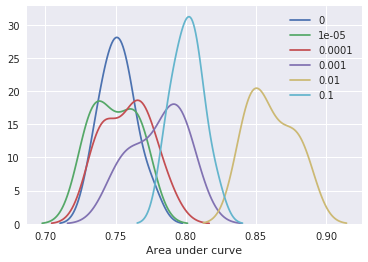

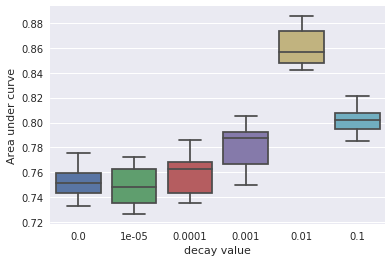

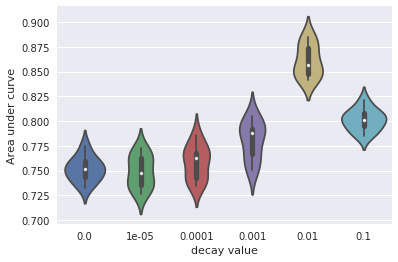


F1 plots:


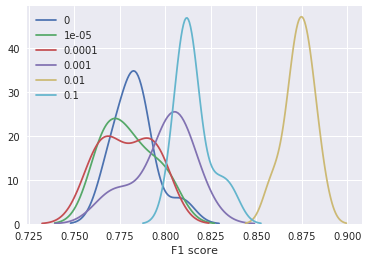

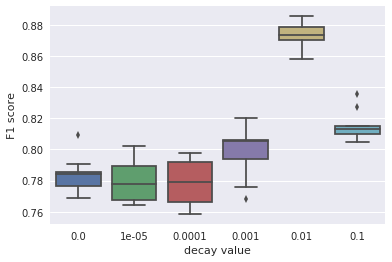

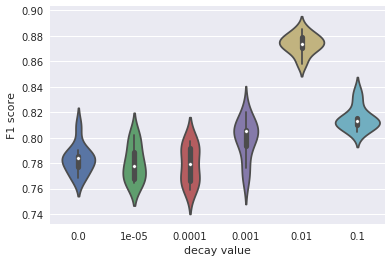


Statistical significance (dependent T-test):
F1 score
                    0          1e-05         0.0001          0.001           0.01            0.1
------  -------------  -------------  -------------  -------------  -------------  -------------
0       nan              0.509477       0.279599       0.0261901      3.20405e-08    0.000276389
1e-05     0.509477     nan              0.865499       0.0388378      7.95692e-08    0.000259578
0.0001    0.279599       0.865499     nan              0.0120095      8.90563e-08    0.000184246
0.001     0.0261901      0.0388378      0.0120095    nan              7.54724e-08    0.00297359
0.01      3.20405e-08    7.95692e-08    8.90563e-08    7.54724e-08  nan              2.80071e-08
0.1       0.000276389    0.000259578    0.000184246    0.00297359     2.80071e-08  nan

Area under curve
                    0          1e-05         0.0001          0.001           0.01            0.1
------  -------------  -------------  -------------  ------------

In [37]:
evaluate.analyze(dict(zip(dropout_values, dropout_tests)), 'dropout rate', '../report/figures/results/dropout')
evaluate.analyze(dict(zip(decay_values, decay_tests)), 'decay value', '../report/figures/results/decay')